<a href="https://colab.research.google.com/github/vmazashvili/AIRO/blob/main/MaskTune_Vano_Mazashvili_1993251.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MaskTune Model

- train an ERM Model (Empirical Risk Minimization)
    - Load and normalize the CIFAR10 training and test datasets using torchvision

    - Define a Convolutional Neural Network

    - Define a loss function

    - Train the network on the training data

Test the network on the test data
- Generate Masks based on Model Outputs
- Fine-tune the Model with Masks
- Testing and Evaluation

In [5]:
!pip install torch torchvision timm
!pip install torchcam
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [6]:
import cv2
import timm
import torch
import random
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchcam.methods import XGradCAM
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

# MNIST DATASET

- [x] Distinguish between two MNIST digit groups (0-4 and 5-9)
- [x] 0-4 into class 0 and 5-9 into class 1.
- [ ] Transform 99% of new class 0 and 1% of the new class 1 so that they acquire same spurious feature (square in top left corner)
- [ ] Two test sets during testing: the original raw MNIST test set and a biased test set.
- [ ] biasd test set - add spurious feature to only 5-9 group  

Load and normalize the MNIST training and test datasets using torchvision. We can Induce spurrious features too



In [7]:
import torch
from torchvision import datasets

def remap_classes(dataset):
    """
    Remap MNIST dataset classes to two new classes
    new_to_old_label_mapping={0: [0, 1, 2, 3, 4], 1: [5, 6, 7, 8, 9]},
    """
    remapped_data = []
    remapped_targets = []

    for data, target in dataset:
        if target < 5:  # Digits 0-4
            remapped_targets.append(0)
        else:  # Digits 5-9
            remapped_targets.append(1)

        remapped_data.append(data)

    return list(zip(remapped_data, remapped_targets))

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='data', train=True, download=True)
mnist_test = datasets.MNIST(root='data', train=False, download=True)

# Remap the classes
remapped_train_data = remap_classes(mnist_train)
remapped_test_data = remap_classes(mnist_test)

# Example usage:
print("Original class distribution in train set:", mnist_train.targets.bincount())
print("Remapped class distribution in train set:", torch.tensor([target for _, target in remapped_train_data]).bincount())

print("Original class distribution in test set:", mnist_test.targets.bincount())
print("Remapped class distribution in test set:", torch.tensor([target for _, target in remapped_test_data]).bincount())


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5858822.65it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 15119282.80it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5335310.88it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7931111.06it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Original class distribution in train set: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
Remapped class distribution in train set: tensor([30596, 29404])
Original class distribution in test set: tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])
Remapped class distribution in test set: tensor([5139, 4861])


In [8]:
remapped_train_data[0]

(<PIL.Image.Image image mode=L size=28x28>, 1)

In [9]:
import random
from PIL import Image, ImageDraw

def add_spurious_feature(image, label, spurious_value=255, percentage_class_0=0.9, percentage_class_1=0.1):
  """
  A function to add a spurious feature to PIL images based on label and class-specific percentages.

  Args:
      image (PIL.Image.Image): Input image.
      label (int): The class label of the image.
      spurious_value (int, optional): Value to assign to the spurious feature pixels. Defaults to 255.
      percentage_class_0 (float, optional): Percentage of class 0 samples to apply the feature to. Defaults to 0.9.
      percentage_class_1 (float, optional): Percentage of class 1 samples to apply the feature to. Defaults to 0.1.

  Returns:
      PIL.Image.Image: Transformed image with the spurious feature added (if applicable).
  """

  # Determine the appropriate percentage based on the class label
  percentage = percentage_class_0 if label == 0 else percentage_class_1

  # Check if the condition for adding the feature is met
  if random.random() < percentage:

        # Create a copy of the input image
        image_with_spurious = image.copy()
        # Create a drawing context
        draw = ImageDraw.Draw(image_with_spurious)
        # Draw a square in the top-left corner
        draw.rectangle([0, 0, 4, 4], fill=(spurious_value,))
        del draw  # Release drawing context
        image_with_spurious = image.copy()
        draw = ImageDraw.Draw(image_with_spurious)
        draw.rectangle([0, 0, 4, 4], fill=(spurious_value,))
        del draw
        return image_with_spurious
  else:
      return image

  return image_with_spurious


# Apply add_spurious_feature to the entire remapped_train_data dataset
remapped_train_data_with_spurious = [(add_spurious_feature(image, label), label) for image, label in remapped_train_data]




In [10]:
from PIL import Image


def add_spurious_feature(image, label, spurious_value=255):
  """
  A function to add a spurious feature to a PIL image for class 1 samples.

  Args:
      image (PIL.Image.Image): Input image.
      label (int): The class label of the image.
      spurious_value (int, optional): Value to assign to the spurious feature pixels. Defaults to 255.

  Returns:
      PIL.Image.Image: Transformed image with the spurious feature added (if applicable).
  """

  if label == 1:
      # Always add the feature to class 1 samples
      image_with_spurious = image.copy()
      draw = ImageDraw.Draw(image_with_spurious)
      draw.rectangle([0, 0, 4, 4], fill=(spurious_value,))
      del draw
      return image_with_spurious
  else:
      return image


# Save remapped_test_data into test_data_raw
test_data_raw = remapped_test_data.copy()  # Create a copy to avoid modifying the original data

# Apply spurious features to class 1 samples in test_data_raw and store in test_data_biased
test_data_biased = []
for image, label in test_data_raw:
  # Apply the feature only to class 1 samples
  image_with_spurious = add_spurious_feature(image, label)
  test_data_biased.append((image_with_spurious, label))



In [11]:
remapped_train_data_with_spurious[0]
test_data_raw[0]
test_data_biased[0]

(<PIL.Image.Image image mode=L size=28x28>, 1)

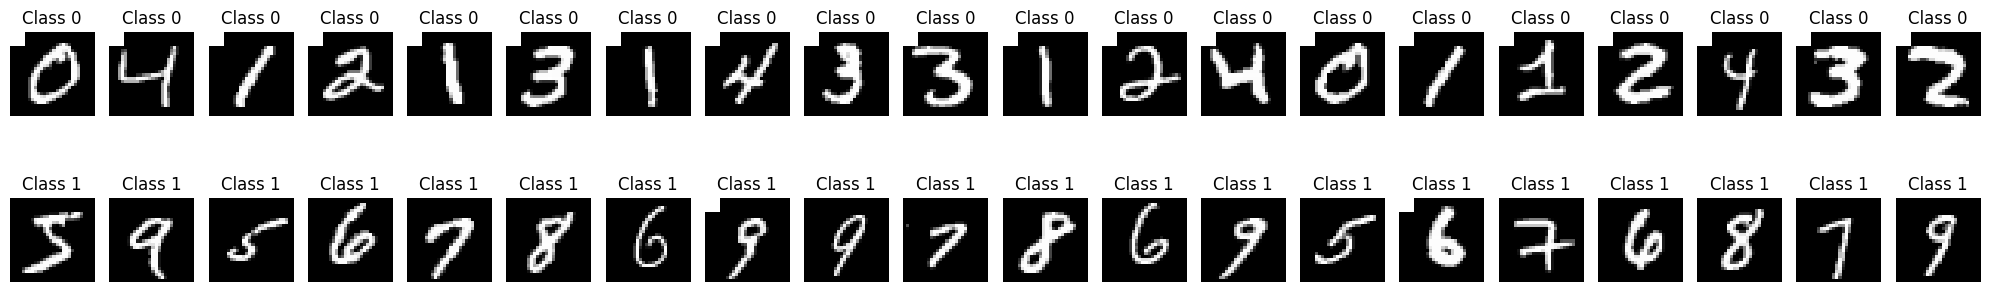

In [12]:
import matplotlib.pyplot as plt

# Initialize counters for each class
class_counts = {0: 0, 1: 0}

# Plot 10 samples for each class
fig, axes = plt.subplots(2, 20, figsize=(20, 4))

for image, label in remapped_train_data_with_spurious:
    # Check if the maximum number of samples for each class is reached
    if class_counts[label] >= 20:
        continue

    # Plot the image
    ax = axes[label][class_counts[label]]
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Class {label}')

    # Increment the counter for the respective class
    class_counts[label] += 1

plt.tight_layout()
plt.show()


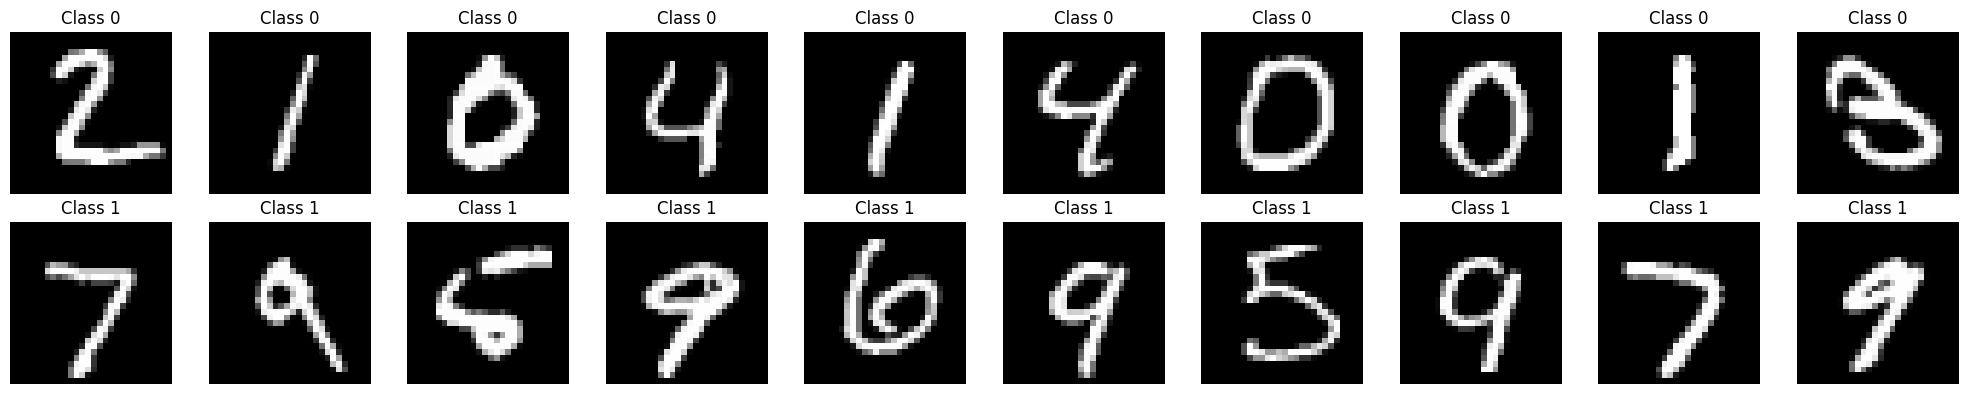

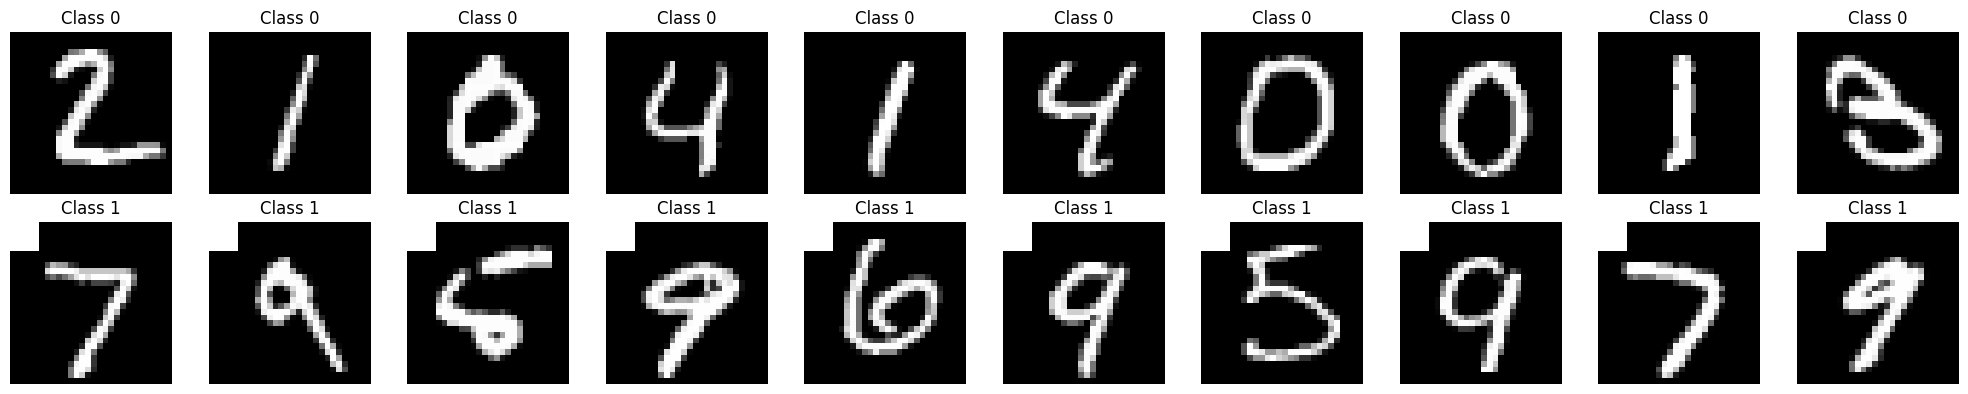

In [13]:
import matplotlib.pyplot as plt

# Initialize counters for each class
class_counts_raw = {0: 0, 1: 0}
class_counts_biased = {0: 0, 1: 0}

# Plot 10 samples for each class from test_data_raw
fig_raw, axes_raw = plt.subplots(2, 10, figsize=(20, 4))

for image, label in test_data_raw:
    # Check if the maximum number of samples for each class is reached
    if class_counts_raw[label] >= 10:
        continue

    # Plot the image
    ax = axes_raw[label][class_counts_raw[label]]
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Class {label}')

    # Increment the counter for the respective class
    class_counts_raw[label] += 1

plt.tight_layout()
plt.show()

# Plot 10 samples for each class from test_data_biased
fig_biased, axes_biased = plt.subplots(2, 10, figsize=(20, 4))

for image, label in test_data_biased:
    # Check if the maximum number of samples for each class is reached
    if class_counts_biased[label] >= 10:
        continue

    # Plot the image
    ax = axes_biased[label][class_counts_biased[label]]
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Class {label}')

    # Increment the counter for the respective class
    class_counts_biased[label] += 1

plt.tight_layout()
plt.show()


Therefore, we should have a training dataset ```remapped_train_data_with_spurious``` with two classes, 0 (containing digits 0-4) and 1 (digits 5-9).
99% of the samples in class 0 have a spurious feature, while 1% of the class 1 has the same spurious feature.

As for testing dataset, we have 2, ```test_data_raw``` and ```test_data_biased```. One will be a raw MNIST test dataset, while the other one will be a modified one with spurious features for class 1 samples.

Thus we have ```test_data_daw```, ```test_data_spurious``` with only class 1 sample spurious features, `remapped_train_data_with_spurious`, and `remapped_train_data`

# Dataloaders
make batches

In [14]:
import torch
from torchvision import transforms

# Define a transform to convert PIL images to tensors
transform = transforms.ToTensor()

# Convert remapped_train_data_with_spurious to tensors
remapped_spurious_train_data_tensor = [(transform(image), label) for image, label in remapped_train_data_with_spurious]

# Convert test_data_raw to tensors
test_data_raw_tensor = [(transform(image), label) for image, label in test_data_raw]
test_data_biased_tesnsor = [(transform(image), label) for image, label in test_data_biased]

In [15]:
biased_train_dataloader = DataLoader(remapped_spurious_train_data_tensor, batch_size=128)
raw_test_dataloader = DataLoader(test_data_raw_tensor, batch_size=128)
biased_test_dataloader = DataLoader(test_data_biased_tesnsor, batch_size=128)
len(biased_train_dataloader)
len(raw_test_dataloader)
len(biased_test_dataloader)

79

# Define CNN
Define a Convolutional Neural Network and give its class a ```get_grad_cam_target_layer``` function which will grab the last convolutional layer to use it for saliency map generation. Uses almost the same architecture as the paper "MaskTune: Mitigating Spurious Correlations by Forcing to Explore"

In [16]:
# Small Convolutional Neural Network

class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Conv2d(16, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            nn.Flatten()
        )

        self.linear = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(256, self.num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.linear(features)
        return logits


    def get_grad_cam_target_layer(self):
        return self.backbone[-5]


### Hyperparameters, optimizer, model selection

In [17]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hyperparameters
lr = 0.01
momentum = 0.9
weight_decay = 1e-4
batch_size = 128
epochs = 20
lr_decay_epochs = 25
lr_decay_factor = 0.5
number_of_classes = 2

# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer with the above presented hyperparameters
model = SmallCNN(number_of_classes)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler to decrease learning rate every lr_decay_epochs epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs, gamma=lr_decay_factor)


# # Hyperparameters

# lr = 0.01
# batch_size = 128
# epochs = 100
# number_of_classes = 2

# loss_function = nn.CrossEntropyLoss()

# # in base_method.py check how we can pass the tailored parameters to the CNN. 10
# model = SmallCNN(number_of_classes)
# optimizer = torch.optim.SGD(model.parameters(), lr = lr)

# model

# Training and Testing
Done with the specified parameters and models above

In [18]:
def train_erm(model, dataloader, optimizer, loss_function, epochs=100):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for xb, yb in dataloader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_function(preds, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            correct_predictions += (preds.argmax(1) == yb).sum().item()
            total_samples += xb.size(0)

        epoch_loss = total_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

def test_model(model, dataloader, loss_function):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for xb, yb in dataloader:
            preds = model(xb)
            loss = loss_function(preds, yb)

            total_loss += loss.item() * xb.size(0)
            correct_predictions += (preds.argmax(1) == yb).sum().item()
            total_samples += xb.size(0)

    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    print(f"Test Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")


In [18]:
# def train_erm(model):
#     for epoch in range(epochs):
#         # Training on unbiased dataset
#         model.train()  # Set model to training mode
#         for xb, yb in biased_train_dataloader:
#             preds = model(xb)
#             loss = loss_function(preds, yb)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#         print(f"Epoch [{epoch+1}/{epochs}], Unbiased Train Loss: {loss.item():.6f}")

#         # Save the model's state dictionary for unbiased training
#         torch.save(model.state_dict(), f'/content/data/MNIST/CNN_checkpoint_epoch_{epoch+1}.pth')

#         # Training on biased dataset
#         model.train()  # Set model to training mode
#         for xb, yb in biased_train_dataloader:
#             preds = model(xb)
#             loss = loss_function(preds, yb)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#         print(f"Epoch [{epoch+1}/{epochs}], Biased Train Loss: {loss.item():.6f}")

#         # Save the model's state dictionary for biased training
#         torch.save(model.state_dict(), f'/content/data/MNIST/CNN_biased_checkpoint_epoch_{epoch+1}.pth')


In [ ]:
# def test(model, dataloader, dataset_type):
#     model.eval()  # Set model to evaluation mode
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in dataloader:
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     accuracy = 100 * correct / total
#     print(f'{dataset_type} Accuracy: {accuracy:.2f}%')

# # Testing on unbiased test dataset
# test(model, test_dataloader, 'Unbiased Test')

# # Testing on biased test dataset
# test(model, biased_test_dataloader, 'Biased Test')


In [14]:
# # training

# def train_erm (model):
#     for xb, yb in biased_train_dataloader:
#         preds = model(xb)
#         loss = loss_function(preds, yb)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     loss = loss.item()
#     print(f"Train loss: {loss:>7f}")

#     # Save the model's state dictionary
#     torch.save(model.state_dict(), '/content/data/MNIST/CNN_checkpoint.pth')



In [15]:
# # testing

# def test_model (model):
#     num_batches = len(test_dataloader)
#     size = len(test_dataloader.dataset)
#     test_loss, corrects = 0,0

#     with torch.no_grad():
#         for xb, yb in test_dataloader:
#             preds=model(xb)
#             test_loss += loss_function(preds,yb).item()
#             corrects += (preds.argmax(1) == yb).type(torch.float).sum().item()

#     test_loss /= num_batches
#     corrects /= size
#     print(f"Test loss: \n Accuracy:{(100*corrects):>0.1f}%, Avg loss:{test_loss:>8f}\n")

In [19]:
# Train the model with biased training dataset
train_erm(model, biased_train_dataloader, optimizer, loss_function, epochs=100)

# Test the model on the raw test dataset
print("Testing on Raw Test Dataset:")
test_model(model, raw_test_dataloader, loss_function)

# Test the model on the biased test dataset
print("Testing on Biased Test Dataset:")
test_model(model, biased_test_dataloader, loss_function)


Epoch 1/100, Loss: 0.0558, Accuracy: 0.9789
Epoch 2/100, Loss: 0.0192, Accuracy: 0.9937
Epoch 3/100, Loss: 0.0122, Accuracy: 0.9964
Epoch 4/100, Loss: 0.0078, Accuracy: 0.9981
Epoch 5/100, Loss: 0.0050, Accuracy: 0.9990
Epoch 6/100, Loss: 0.0033, Accuracy: 0.9996
Epoch 7/100, Loss: 0.0022, Accuracy: 0.9998
Epoch 8/100, Loss: 0.0015, Accuracy: 1.0000
Epoch 9/100, Loss: 0.0011, Accuracy: 1.0000
Epoch 10/100, Loss: 0.0008, Accuracy: 1.0000
Epoch 11/100, Loss: 0.0007, Accuracy: 1.0000
Epoch 12/100, Loss: 0.0005, Accuracy: 1.0000
Epoch 13/100, Loss: 0.0004, Accuracy: 1.0000
Epoch 14/100, Loss: 0.0004, Accuracy: 1.0000
Epoch 15/100, Loss: 0.0003, Accuracy: 1.0000
Epoch 16/100, Loss: 0.0003, Accuracy: 1.0000
Epoch 17/100, Loss: 0.0003, Accuracy: 1.0000
Epoch 18/100, Loss: 0.0003, Accuracy: 1.0000
Epoch 19/100, Loss: 0.0002, Accuracy: 1.0000
Epoch 20/100, Loss: 0.0002, Accuracy: 1.0000
Epoch 21/100, Loss: 0.0002, Accuracy: 1.0000
Epoch 22/100, Loss: 0.0002, Accuracy: 1.0000
Epoch 23/100, Loss:

In [16]:
# for t in range(1):
#     train_erm(model)
#     test_model(model)
#     #test(model, biased_train_dataloader, dataset_type='Biased')


Train loss: 0.001844
Test loss: 
 Accuracy:98.2%, Avg loss:0.049803



# Generating Saliency Map using XGradCAM
Implementing explainability.
Using the, for example, last convolutional layer from the trained CNN checkpoint to generate the gradient and hook.
Pass a random instance from each class to the trained model. The model, target layer from the trained network and the network output are used to generate a saliency_map which is interpolated and projected onto the appropriate input image.

In [20]:
def generate_map(sample_data, sample_class):
    checkpoint = torch.load('/content/data/MNIST/CNN_checkpoint.pth') # Load the saved model checkpoint
    model.load_state_dict(checkpoint)
    # Don’t forget to set your model into the evaluation mode, otherwise you can get very random results
    model.eval() # Set the model to evaluation mode

    # Get the target layer
    target_layer = model.get_grad_cam_target_layer() # Last convolutional layer is the target
    # Prepare the input tensor
    input_tensor = sample_data # a sample from the dataset passed to the function

    cam = XGradCAM(model, target_layer)
    output = model (input_tensor.unsqueeze(0))
    saliency_map = cam(class_idx = sample_class, scores = output)

    # Now we can visualize the saliency map
    # Get the first saliency map tensor from the list
    saliency_map_tensor = saliency_map[0]

    # Convert the saliency map tensor to a numpy array
    saliency_map_np = saliency_map_tensor.detach().cpu().numpy()

    # Reshape the saliency map to 2D
    saliency_map_np = saliency_map_np.reshape(saliency_map_np.shape[1:])

    # Visualize or process the saliency map as needed
    # For example, you can plot it as an image
    #plt.imshow(saliency_map_np, cmap='hot', interpolation='nearest')
    #plt.axis('off')
    #plt.show()

    return saliency_map_np

In [21]:
def interpolate_heatmap(input_tensor, saliency_map_np):
    # Convert the input tensor to a numpy array image
    input_img_np = input_tensor.squeeze(0).cpu().numpy()
    input_img_np = np.uint8(255 * input_img_np)

    # Resize the saliency map to match the size of the original image
    heatmap_resized = cv2.resize(saliency_map_np, (input_img_np.shape[1], input_img_np.shape[0]))

    # Normalize the saliency map values to the range [0, 255]
    heatmap_resized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized)) * 255
    heatmap_resized = np.uint8(heatmap_resized)

    # Convert the original image to a BGR format
    input_img_bgr = cv2.cvtColor(input_img_np, cv2.COLOR_GRAY2BGR)

    # Apply a colormap to the saliency map to convert it into a heatmap image
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Resize the heatmap image to match the size of the original image
    heatmap_colored_resized = cv2.resize(heatmap_colored, (input_img_np.shape[1], input_img_np.shape[0]))

    # Overlay the heatmap image onto the original image
    superimposed_img = cv2.addWeighted(input_img_bgr, 0.7, heatmap_colored_resized, 0.3, 0)

    return superimposed_img


In [22]:
import random

# Dictionary to store interpolated images by class label
interpolated_images_by_class = {}

# Function to generate and interpolate the heatmap for one instance of each class
def generate_and_interpolate_heatmap_one_per_class():
    # Create a dictionary to hold the data instances for each class
    class_data_dict = {}

    # Iterate through the training data
    for data, label in remapped_spurious_train_data_tensor:
        if label not in class_data_dict:
            class_data_dict[label] = []
        class_data_dict[label].append(data)
    # Iterate through each class label
    for class_label in range(10):  # Assuming 10 classes (0 to 9)
        # Get the data instances for the specified class label
        class_data = class_data_dict.get(class_label, [])

        # Select one random instance from the class data
        if class_data:
            random_instance = random.choice(class_data)

            # Generate the saliency map for the random instance
            saliency_map_np = generate_map(random_instance, class_label)

            # Interpolate the heatmap for the random instance
            interpolated_img = interpolate_heatmap(random_instance, saliency_map_np)

            # Store the interpolated image in the dictionary by class label
            interpolated_images_by_class[class_label] = interpolated_img

# Generate interpolated images for one instance per class
generate_and_interpolate_heatmap_one_per_class()

# Plot the interpolated images with their class labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flat):
    class_label = i
    interpolated_img = interpolated_images_by_class.get(class_label)
    if interpolated_img is not None:
        ax.imshow(interpolated_img, cmap='hot', interpolation='nearest')
        ax.axis('off')
        ax.set_title(f'Class {class_label}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/data/MNIST/CNN_checkpoint.pth'

In [ ]:
import torch
import numpy as np
import cv2

def accumulate_and_plot_average_saliency_map(train_data_biased, generate_map, class_label_to_accumulate, num_maps_to_accumulate=20):
    # List to store accumulated saliency maps for the chosen class label
    accumulated_saliency_maps = []

    # Function to accumulate the input tensors for the chosen class label
    def accumulate_inputs():
        # List to store accumulated input tensors for the chosen class label
        accumulated_inputs = []

        # Iterate through the training data
        for data in remapped_spurious_train_data_tensor:
            input_tensor, class_label = data

            # Check if the class label matches the chosen class label
            if class_label == class_label_to_accumulate:
                # Accumulate the input tensor
                accumulated_inputs.append(input_tensor)

        return accumulated_inputs

    # Accumulate the input tensors for the chosen class label
    accumulated_inputs = accumulate_inputs()

    # Function to generate and accumulate the saliency maps for the chosen class label
    def accumulate_saliency_maps():
        nonlocal accumulated_saliency_maps
        # Generate saliency maps for the chosen class label
        for _ in range(num_maps_to_accumulate):
            # Choose a random input tensor from the accumulated inputs
            input_tensor = random.choice(accumulated_inputs)

            # Generate the saliency map for the chosen input tensor
            saliency_map = generate_map(input_tensor, class_label_to_accumulate)

            # Accumulate the saliency map
            accumulated_saliency_maps.append(saliency_map)

    # Generate and accumulate saliency maps for the chosen class label
    accumulate_saliency_maps()

    # Convert the list of accumulated saliency maps to a numpy array
    accumulated_saliency_maps_array = np.array(accumulated_saliency_maps)

    # Compute the average saliency map
    average_saliency_map = np.mean(accumulated_saliency_maps_array, axis=0)

    # Interpolate the average saliency map to match the size of the original input image (28x28)
    interpolated_avg_saliency_map = cv2.resize(average_saliency_map, (28, 28), interpolation=cv2.INTER_LINEAR)

    # Plot the interpolated average saliency map
    # plt.imshow(interpolated_avg_saliency_map, cmap='hot', interpolation='nearest')
    # plt.axis('off')
    # plt.title('Interpolated Average Saliency Map for Class {}'.format(class_label_to_accumulate))
    # plt.show()

    return interpolated_avg_saliency_map


In [ ]:
interpolated_images_by_class = {}

for class_label in range(number_of_classes):
    interpolated_img = accumulate_and_plot_average_saliency_map(remapped_spurious_train_data_tensor, generate_map, class_label_to_accumulate=class_label)
    interpolated_images_by_class[class_label] = interpolated_img

# Plot the interpolated images with their class labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flat):
    class_label = i
    interpolated_img = interpolated_images_by_class.get(class_label)
    if interpolated_img is not None:
        ax.imshow(interpolated_img, cmap='hot', interpolation='nearest')
        ax.axis('off')
        ax.set_title(f'Class {class_label}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


TODO:
start implementing MaskTune for MNIST

- [x] **ISSUE:** The transformation function transforms every instance in the dataset instead of the ones of the chosen class
- [x] Create a biased MNIST dataset - for it to work, induce spurious feature to one class so the model will pick up the easyeast detectable feature. If the bias is applied to every class, the result wont change because during training, the model is forced to focus on other features in order to predict correctly.
- [ ] See how it performs compared to unbised MNIST

---

- [ ] def `finetune` (finetune erm checkpoint with ```masktune```)
- [ ] def ```masktune```
- [ ] def ```finetune```

---

- [ ] Compare performances and saliency matrices between unbiased and biased MNIST datasets



